In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

In [2]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.SppN.mean()

5.1824128104220382

In [4]:
import geopandas as gpd

In [5]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [6]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [7]:
new_data.crs = {'init':'epsg:4326'}


### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [8]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")
new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)

In [9]:
new_data['logBiomass'] = np.log(new_data.plotBiomass)
new_data['logSppN'] = np.log(new_data.SppN)

In [10]:
## Let´s make a simple linear trend here.
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [11]:
## All data
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='logBiomass ~ logSppN',data=new_data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4757.
Date:                Tue, 21 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:46:04   Log-Likelihood:                -36670.
No. Observations:               36845   AIC:                         7.334e+04
Df Residuals:                   36843   BIC:                         7.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.4882      0.009    976.347      0.000         8.471     8.505
logSppN        0.3740      0.005     68.974      0.000         0.363     0.385
==============================================================================
Omnibus:                     1627.980   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2356.149
Skew:                          -0.421   Prob(JB):                         0.00
Kurtosis:                       3.908   Cond. No.                         5.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
new_data['residuals1'] = results.resid

## The area is very big -> 35000 points. 
We need to make a subset of this


(4657, 47)

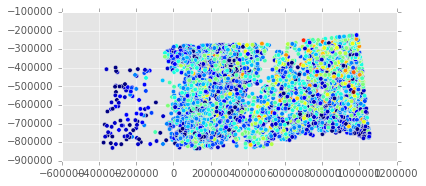

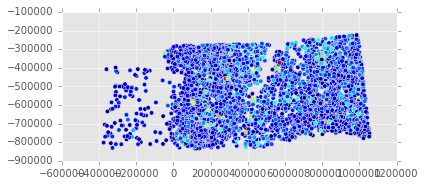

In [13]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -100) & (x.LON < -85) & (x.LAT > 30) & (x.LAT < 35) ]
section.plot(column='SppN')
section.plot(column='plotBiomass')
section.shape


### Residuals

In [14]:
Y_hat = results.predict(section)

In [15]:
ress = (section.logBiomass - Y_hat)

In [16]:
param_model.Intercept

8.488195471616315

,0,1
Intercept,8.471155,8.505236
logSppN,0.363325,0.384578


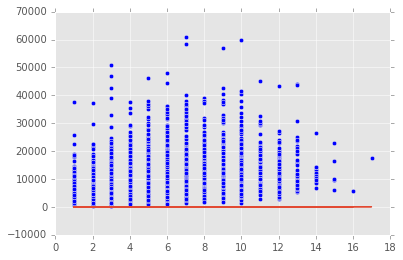

In [17]:
conf_int = results.conf_int(alpha=0.05)
plt.scatter(section.SppN,section.plotBiomass)
#plt.plot(section.SppN,param_model.Intercept + param_model.SppN * section.SppN)

plt.plot(section.SppN,Y_hat)
#plt.fill_between(Y_hat,Y_hat + conf_int , Y_hat - conf_int)
conf_int

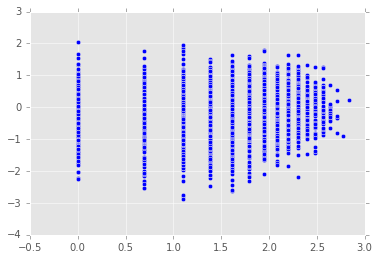

In [20]:
plt.scatter(section.logSppN,section.residuals1)

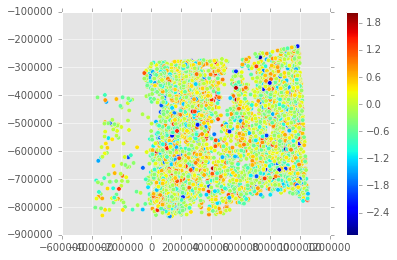

In [23]:
plt.scatter(section.newLon,section.newLat,c=section.residuals1)
plt.colorbar()

In [24]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=0.2, active_dims = [0,1] ) + gf.kernels.Constant(2,active_dims=[0,1])

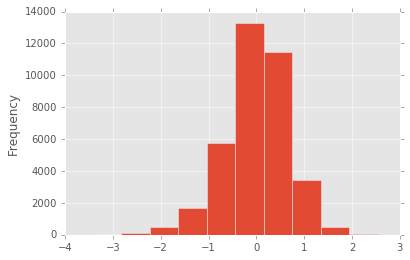

In [25]:
results.resid.plot.hist()

In [28]:
model = gf.gpr.GPR(section[['newLon','newLat']].as_matrix(),section.residuals1.values.reshape(-1,1),k)

In [29]:
%time model.optimize()

CPU times: user 28min 25s, sys: 30.9 s, total: 28min 56s
Wall time: 10min 32s


      fun: 4417.2589165690879
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.31733145e-05,  -0.00000000e+00,  -2.29640029e-05,
        -2.29639988e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 18
   status: 0
  success: True
        x: array([-5.23780247, -1.50777732, -1.53581048, -1.53581191])

In [30]:
k.get_parameter_dict()

{'name.kern.constant.variance': array([ 0.00529886]),
 'name.kern.matern12.lengthscales': array([ 0.2]),
 'name.kern.matern12.variance': array([ 0.19497644])}

In [ ]:
model.get_parameter_dict()

In [ ]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [ ]:
predicted_coordinates.shape

In [ ]:
means,variances = model.predict_y(predicted_coordinates)

In [ ]:
sum(means)

In [ ]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

In [ ]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data



## Model Analysis with the empirical variogram


In [31]:
from external_plugins.spystats import tools

In [32]:
vg = tools.Variogram(section,'logBiomass',using_distance_threshold=600000)

In [ ]:
vg.plot(num_iterations=30)

In [33]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget
    return g_h

In [34]:
hx = np.linspace(0,600000,100)
vg = tools.Variogram(section,'residuals1',using_distance_threshold=500000)

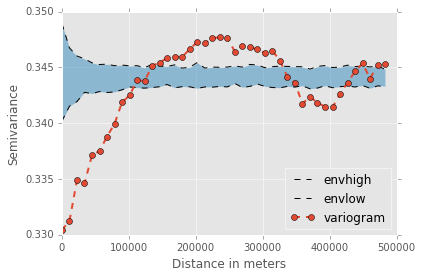

In [35]:
vg.plot(num_iterations=90)

In [71]:
hx = np.linspace(0,600000,100)
vg = tools.Variogram(section,'residuals1',using_distance_threshold=500000)
## already fitted previously
s = 0.345255240992
r = 65857.797111
nugget = 0.332850902482

In [84]:
def gaussianVariogram(h,sill=0,range_a=0,nugget=0):
    g_h = ((sill - nugget)*(1 - np.exp(-(h**2 / range_a**2)))) + nugget
    return g_h


fitted_gaussian = lambda x : gaussianVariogram(x,s,r,nugget)

In [85]:
Mdist = vg.distance_coordinates.flatten()

In [109]:
%time gs = np.array(map(fitted_gaussian,hx))

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 251 µs


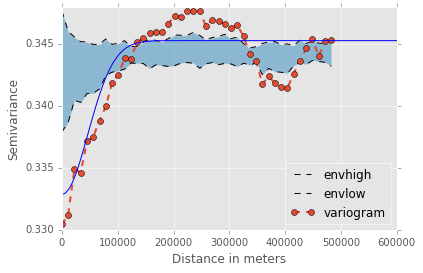

In [116]:
x = vg.plot(with_envelope=True,num_iterations=30,refresh=False)
plt.plot(hx,gs,color='blue')


In [118]:
import statsmodels.regression.linear_model as lm

In [123]:
CovMat = vars.reshape(len(section),len(section))
X = section.logSppN.values
Y = section.logBiomass.values


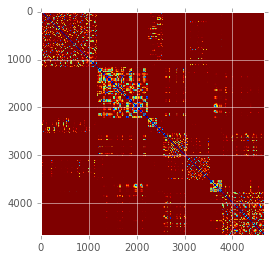

In [128]:
plt.imshow(CovMat)

In [130]:
%time model = lm.GLS(Y,X,sigma=CovMat.transpose())

LinAlgError: Matrix is not positive definite

In [ ]:
%time results = model.fit()